In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import json
import seaborn as sns
import numpy as np
from matplotlib import cm
import statistics as stat

In [3]:
porosity = 0.2382823
volume = 900*900*1600
nuw = 0.066666667
nun = 0.066666667
K_md = 1850 
mDarcy=1013.25 
cases_data = json.load(open('./Data/Bent_extracted.json'))

# Get vo, vp, and vm for each curve (case)

In [7]:
for case in cases_data:
    krw = [i*mDarcy/K_md for i in case['Krwc']] # keff to kr
    krn = [i*mDarcy/K_md for i in case['Krnc']]
    sw = case['sw']
    l = len(case['sw'])
    
    #get vp for all points 
    vp_vo = [nuw *((i/nuw)+(j/nun)) for i, j in zip(krw,krn)] #vp/vo
    
    # get vm using the derivative of vp/vo
    d_vp_vo_dsw = []
    vm_vo = []
    for i in range (l):
        if i ==0: #first point, forward derivative
            d_vp_vo_i = vp_vo[i+1]- vp_vo[i]  # d(vp/vo)
            d_sw_i = sw[i+1] - sw[i] # dSw
            
        elif i == (l-1): #last point, backward derivative
            d_vp_vo_i = vp_vo[i]- vp_vo[i-1] 
            d_sw_i = sw[i] - sw[i-1] 
            
        else: # intermediate points, take the average of the forward and backward derivatives
            d_vp_vo_i = 0.5 * ((vp_vo[i+1]- vp_vo[i]) + (vp_vo[i]- vp_vo[i-1]))
            d_sw_i = 0.5 * ((sw[i+1] - sw[i]) + (sw[i] - sw[i-1]))
            
        d_vp_vo_dsw_i = d_vp_vo_i/d_sw_i  # d(vp/vo)/dSw
        vm_vo_i = d_vp_vo_dsw_i + nuw*(krn[i]/((1-sw[i])*nun)-krw[i]/(sw[i]*nuw)) #updated
        d_vp_vo_dsw.append(d_vp_vo_dsw_i)
        vm_vo.append(vm_vo_i)
        
    case['vp_vo'] = vp_vo
    case['d_vp_vo_dsw'] = d_vp_vo_dsw
    case['vm_vo'] = vm_vo

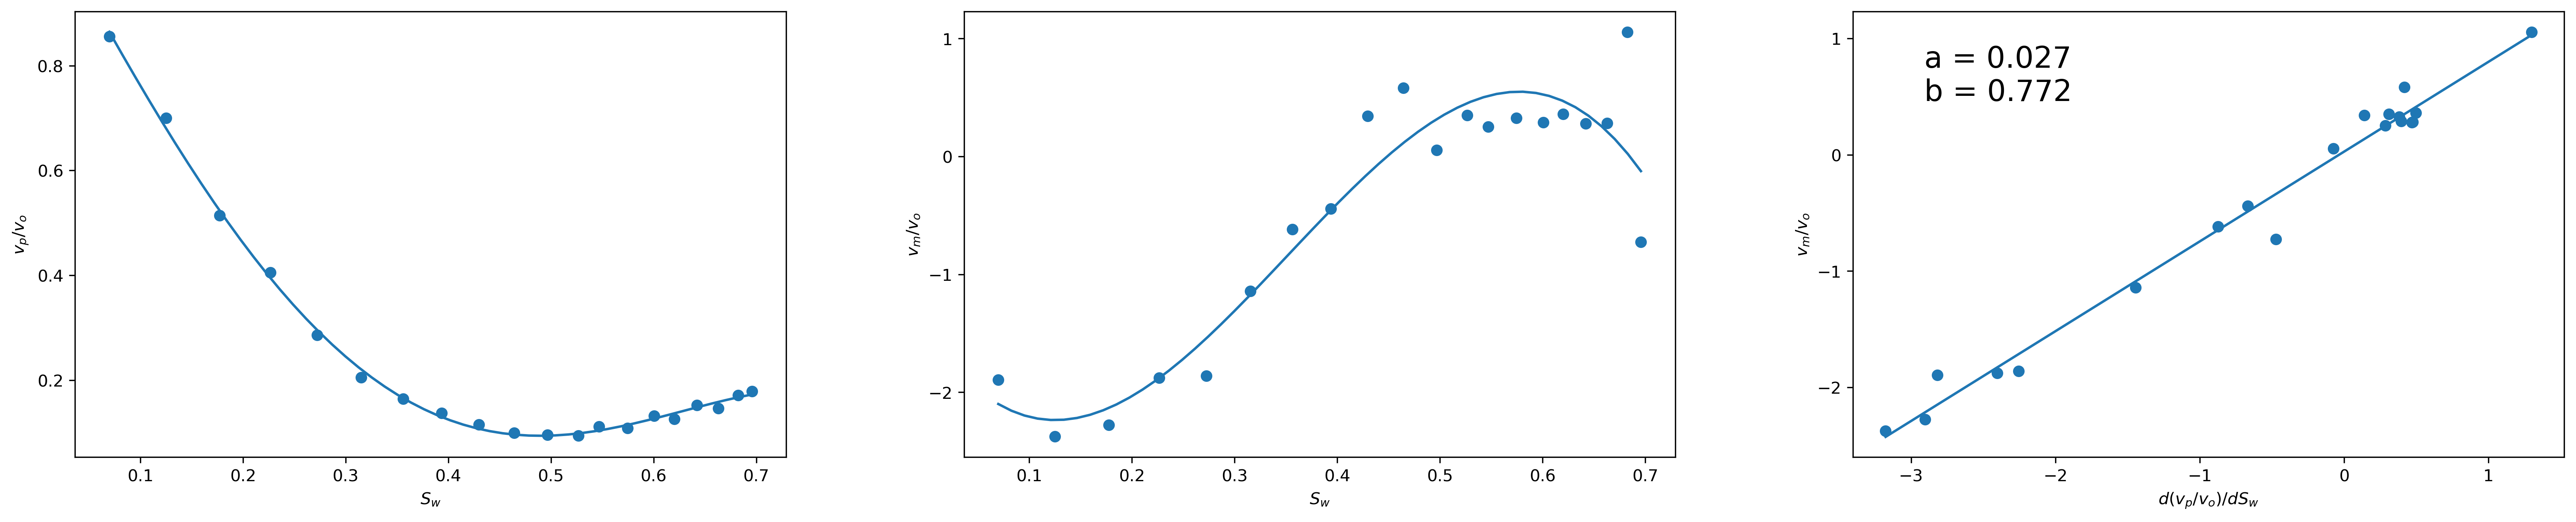

findfont: Font family ['SerifFamily1'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SerifFamily1'] not found. Falling back to DejaVu Sans.


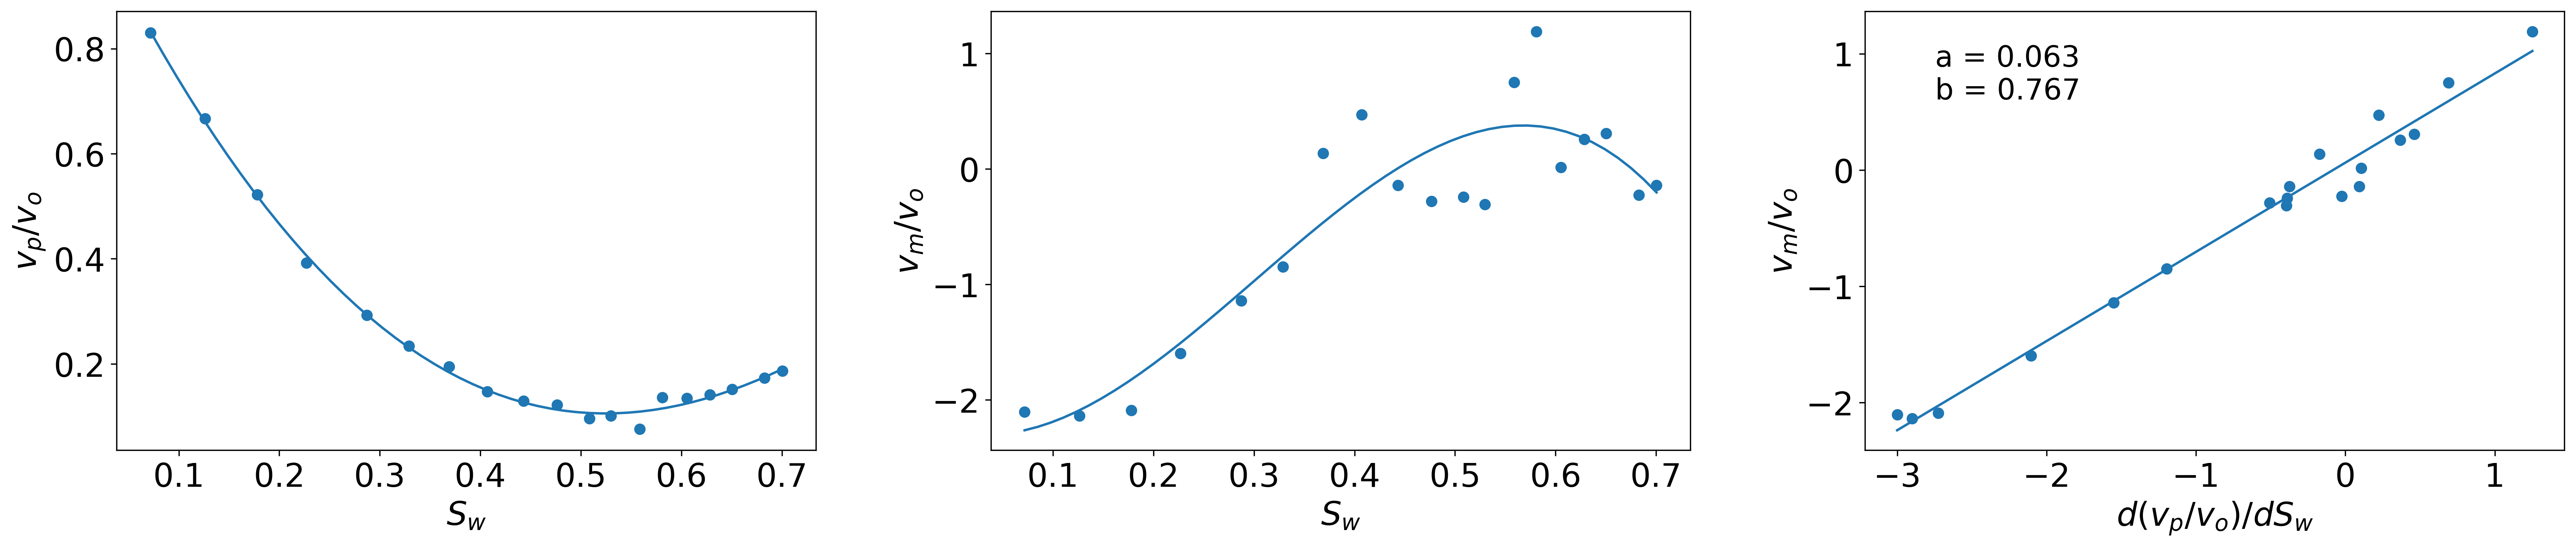

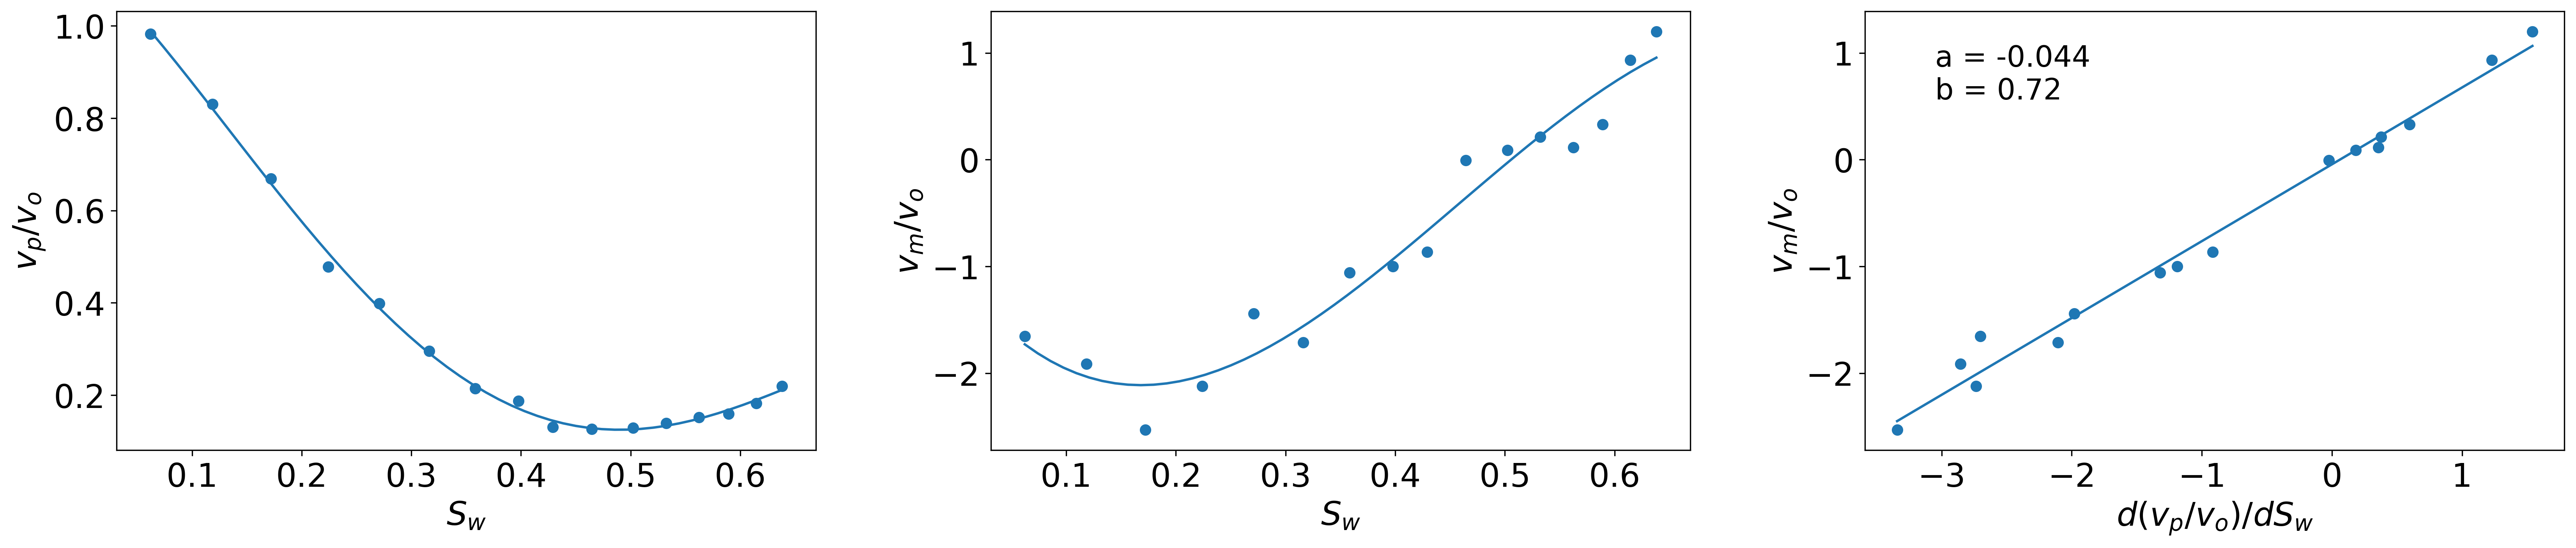

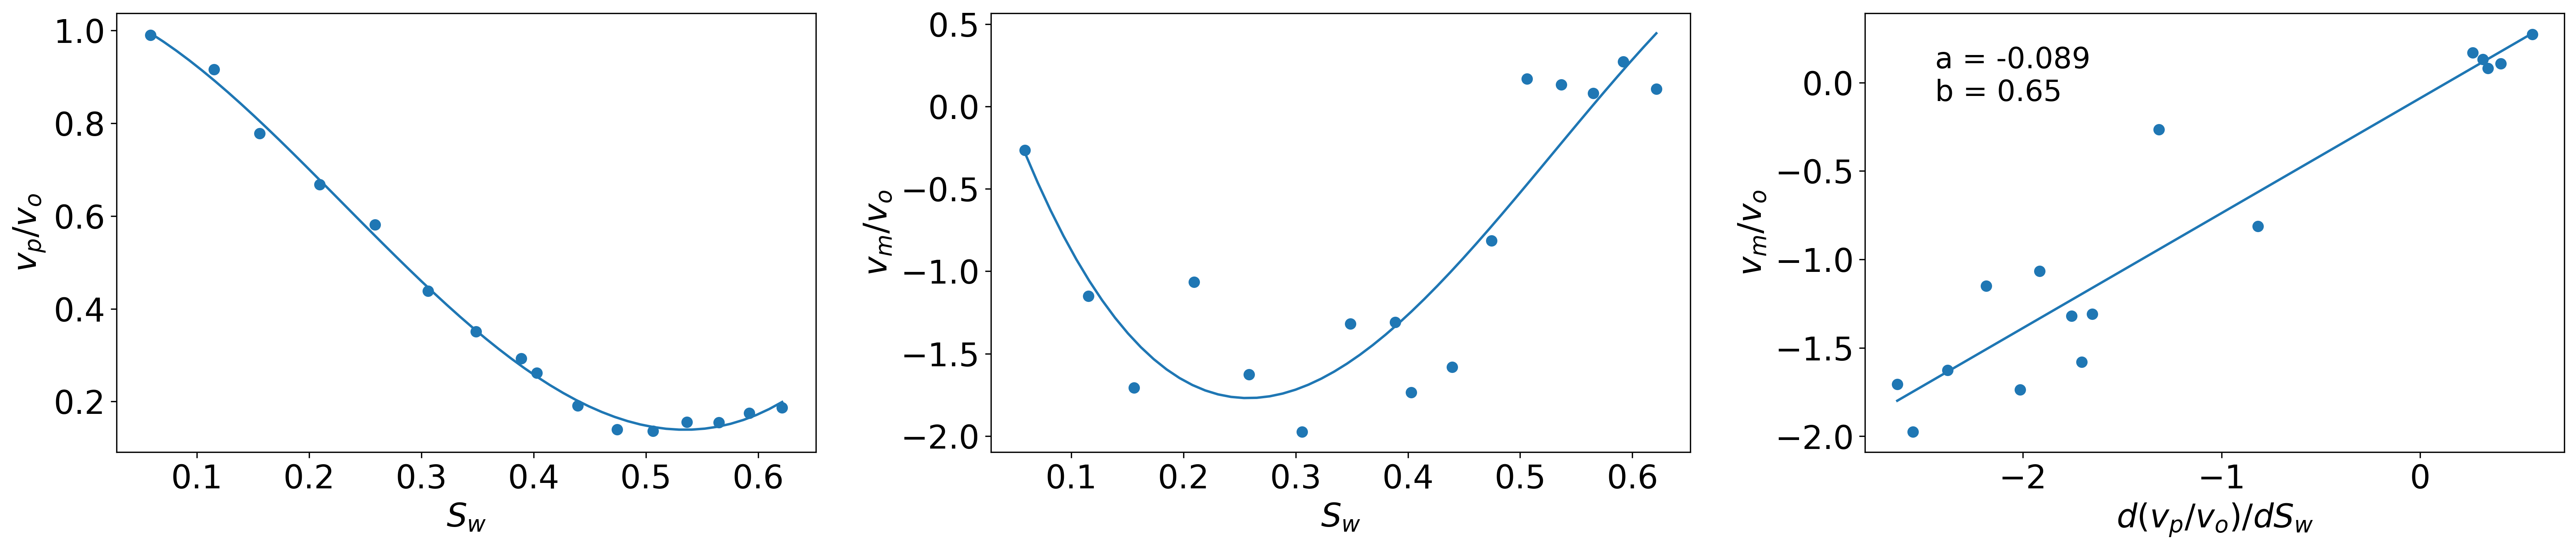

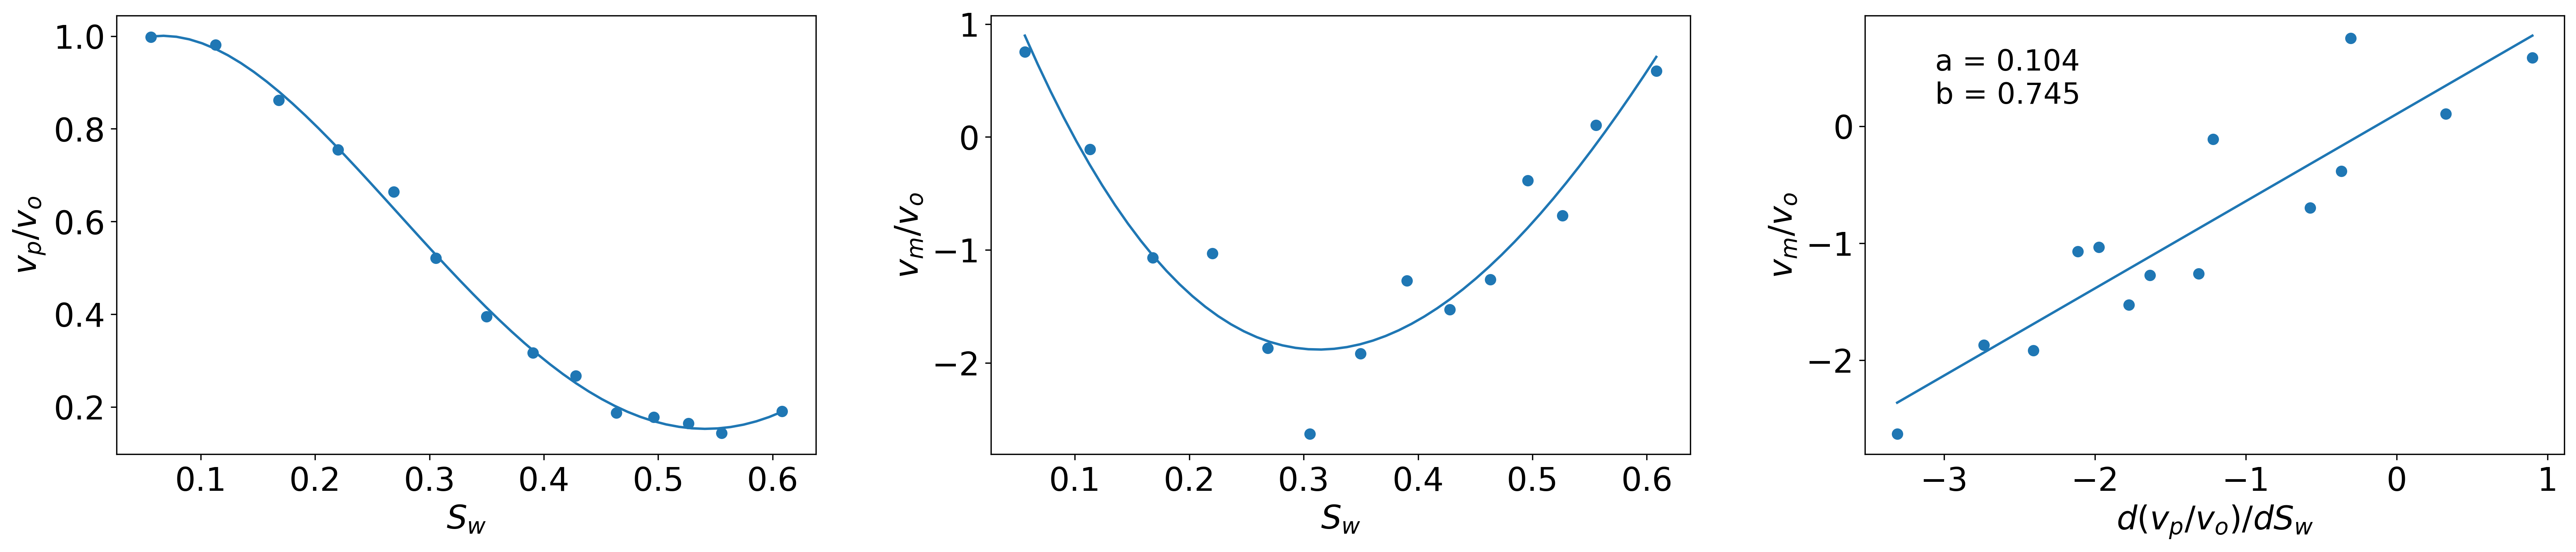

In [8]:
def fit_line(x,y, degree):
    z = np.polyfit(x, y, degree)
    f = np.poly1d(z)
    # calculate new x's and y's
    x_new = np.linspace(min(x), max(x), 50)
    y_new = f(x_new)
    return(x_new, y_new, f)

x_all1 = []
y_all1 = []
x_all2 = []
y_all2 = []
x_all3 = []
y_all3 = []
w_all = []

a = []
b = []
for k, case in enumerate (cases_data):

    plt.figure(k+1, figsize=(23,5), dpi=300)
    plt.subplot(1,3,1)
    plt.scatter(case['sw'], case['vp_vo'])
    x_new1, y_new1, _ = fit_line(case['sw'], case['vp_vo'],4)
    plt.plot(x_new1, y_new1)
    plt.xlabel('${S_w}$'), plt.ylabel('${v_p}/{v_o}$')
    #plt.title(str(k+1)+' Wettability: '+str(round(case['wet_case'],2)), fontsize =22)
    
    plt.subplot(1,3,2)
    plt.scatter(case['sw'], case['vm_vo'])
    x_new2, y_new2, _ = fit_line(case['sw'], case['vm_vo'],3)
    plt.plot(x_new2, y_new2 )
    plt.xlabel('${S_w}$'), plt.ylabel('${v_m}/{v_o}$')
    
    ax = plt.subplot(1,3,3)
    plt.scatter(case['d_vp_vo_dsw'], case['vm_vo'])
    x_new3, y_new3, f = fit_line(case['d_vp_vo_dsw'], case['vm_vo'],1)
    a.append(f[0])
    b.append(f[1])
    plt.plot(x_new3, y_new3)
    t = 'a = '+str(round(f[0],3))+'\nb = '+str(round(f[1],3))
    plt.text(0.1, 0.8, t, fontsize =18, transform=ax.transAxes)
    plt.xlabel('$d({v_p}/{v_o})/{dS_w}$'), plt.ylabel('${v_m}/{v_o}$')
    plt.rcParams.update({'font.size': 20, 'font.family': 'SerifFamily1'})
    plt.subplots_adjust(left=0.08,
                bottom=0.2, 
                right=0.99, 
                top=0.95, 
                wspace=0.25, 
                hspace=0.1)
    #plt.savefig(os.path.join('./figures/Bent/', str(round(case['wet_case'],2))+'_wett.png'), dpi=300)
    x_all3.extend(x_new3)
    y_all3.extend(y_new3)
    w_all.extend([case['wet_case'] for i in range (len(x_new1))])
    x_all1.extend(x_new1)
    y_all1.extend(y_new1)
    x_all2.extend(x_new2)
    y_all2.extend(y_new2)

findfont: Font family ['SerifFamily1'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SerifFamily1'] not found. Falling back to DejaVu Sans.


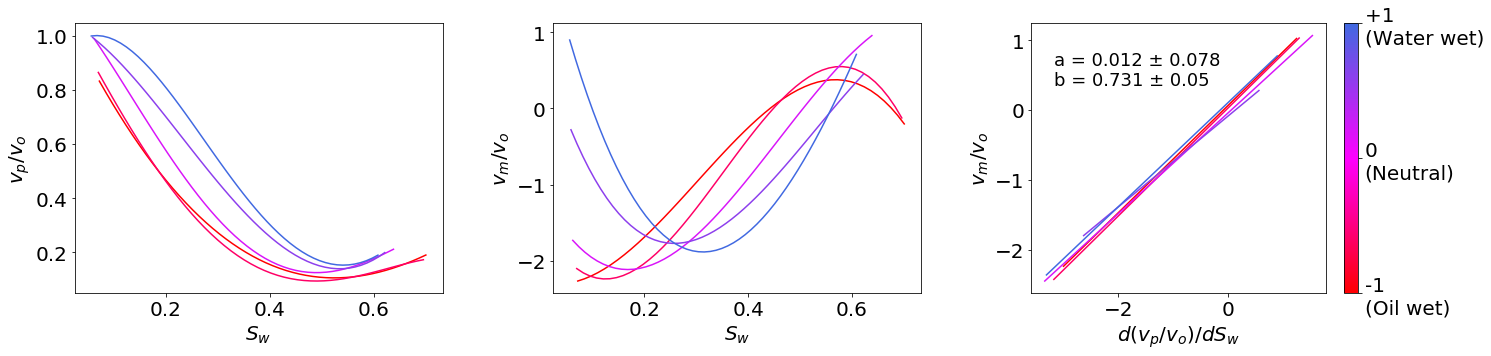

In [9]:
norm=plt.Normalize(1,150)
colorlist=['red','magenta',"royalblue"]
newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
palette= newcmp#'cool'

ff = 20
rc = {'figure.dpi':300,
                  "font.size":1,
                  #"axes.titlesize":20,
                  "axes.labelsize":ff,
                  'xtick.bottom': True,
                  'ytick.left': True,
                 'xtick.labelsize' : ff,
                 'ytick.labelsize' : ff,
                 'axes.labelpad': ff}
# to add a and b 
a_avg = round(stat.mean(a),3)
a_std = round(stat.stdev(a),3)
b_avg = round(stat.mean(b),3)
b_std = round(stat.stdev(b),3)
t = 'a = '+str(a_avg) +' \u00b1 '+ str(a_std)+'\nb = '+str(b_avg) +' \u00b1 '+ str(b_std)
pos1, pos2 = sorted(cases_data[0]['d_vp_vo_dsw'])[0], sorted(cases_data[0]['vm_vo'])[-4]


plt.figure(1, figsize=(23,5))
plt.subplot(1,3,1)
ax1 = sns.lineplot(x=x_all1, y=y_all1, hue=w_all, palette= palette)
ax1.set(xlabel='${S_w}$', ylabel='${v_p}/{v_o}$')
ax1.get_legend().remove()

plt.subplot(1,3,2)
ax2 = sns.lineplot(x=x_all2, y=y_all2, hue=w_all, palette= palette)
ax2.set(xlabel='${S_w}$', ylabel='${v_m}/{v_o}$')
ax2.get_legend().remove()

plt.subplot(1,3,3)
ax2 = sns.lineplot(x=x_all3, y=y_all3, hue=w_all, palette= palette)
ax2.set(xlabel='$d({v_p}/{v_o})/{dS_w}$', ylabel='${v_m}/{v_o}$')
ax2.get_legend().remove()

ax2.text(pos1, pos2, t, fontsize =18)

norm = plt.Normalize(-1,1)#(min(all_wet), max(all_wet))
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

cbar = ax2.figure.colorbar(sm,ticks=[-1,0, 1])
cbar.ax.set_yticklabels(['-1 \n(Oil wet)','0 \n(Neutral)', '+1 \n(Water wet)']) 
#cbar.ax.set_yticklabels(['Oil wet', 'Water wet']) 

sns.set_theme(rc=rc,
              style="white")

                 #'figure.figsize':(11.7,8.27),
plt.subplots_adjust(left=0.1,
                    bottom=0.15, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.2)
#plt.savefig(os.path.join('./figures/Bent/', 'all_cases_bent.png'), dpi=300, pad_inches = 0, bbox_inches = 'tight')
plt.show()    
